In [1]:
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np 
import tensorflow as tf 
import re 
from tensorflow.keras.preprocessing.text import Tokenizer
import tensorflow as tf
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score
import seaborn as sns 
plt.style.use('ggplot')

Read the data 

In [2]:
df_train = pd.read_csv('/kaggle/input/fake-news-detection-data/train.csv')

Checking for null values 

In [3]:
df_train.isnull().sum()

id           0
title      558
author    1957
text        39
label        0
dtype: int64

fill the NaN values with " "

In [4]:
df_train.fillna(" ", inplace=True)

Drop the date from the dataset, I don't think there is a strong correlation between date and validity of the news. As we see above, subjects are not distributed evenly. We do not want that to influence the accuracy of our classifier. Therefore, we need to drop that as well. 

In [5]:
df_train['news'] = df_train['author'] + " : " +df_train['title']

Split into training and testing 

In [25]:
features = df_train['news']
targets = df_train['label']

X_train, X_test, Y_train, Y_test = train_test_split(features, targets, test_size=0.20, random_state=18)

Normalizing our data: lower case, get rid of extra spaces, and url links. 

In [26]:
def normalize(data):
    normalized = []
    for i in data:
        i = i.lower()
        # get rid of urls
        i = re.sub('https?://\S+|www\.\S+', '', i)
        # get rid of non words and extra spaces
        i = re.sub('\\W', ' ', i)
        i = re.sub('\n', '', i)
        i = re.sub(' +', ' ', i)
        i = re.sub('^ ', '', i)
        i = re.sub(' $', '', i)
        normalized.append(i)
    return normalized

X_train = normalize(X_train)
X_test = normalize(X_test)

In [27]:
max_vocab = 10000
tokenizer = Tokenizer(num_words=max_vocab)
tokenizer.fit_on_texts(X_train)

Convert text to vectors, our classifier only takes numerical data. 

In [28]:
# tokenize the text into vectors 
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

Apply padding so we have the same length for each article 

In [29]:
sent_length= 256

In [30]:
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train, padding='post', maxlen=sent_length)
X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test, padding='post', maxlen=sent_length)

Building the RNN.

In [33]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(max_vocab, 32,input_length=sent_length),
    tf.keras.layers.SimpleRNN(64, return_sequences=True),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.SimpleRNN(16),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 256, 32)           320000    
_________________________________________________________________
simple_rnn_8 (SimpleRNN)     (None, 256, 64)           6208      
_________________________________________________________________
dropout_7 (Dropout)          (None, 256, 64)           0         
_________________________________________________________________
simple_rnn_9 (SimpleRNN)     (None, 16)                1296      
_________________________________________________________________
dense_8 (Dense)              (None, 64)                1088      
_________________________________________________________________
dropout_8 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 1)                

We are going to use early stop, which stops when the validation loss no longer improve.

In [34]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

history = model.fit(X_train, Y_train, epochs=10,validation_split=0.1, batch_size=30, shuffle=True, callbacks=[early_stop])

Epoch 1/10
500/500 [==============================] - 66s 133ms/step - loss: 0.6660 - accuracy: 0.6997 - val_loss: 0.5812 - val_accuracy: 0.8684
Epoch 2/10
500/500 [==============================] - 65s 130ms/step - loss: 0.5527 - accuracy: 0.9167 - val_loss: 0.5359 - val_accuracy: 0.9441
Epoch 3/10
500/500 [==============================] - 65s 131ms/step - loss: 0.5267 - accuracy: 0.9577 - val_loss: 0.5386 - val_accuracy: 0.9351
Epoch 4/10
500/500 [==============================] - 65s 129ms/step - loss: 0.5190 - accuracy: 0.9696 - val_loss: 0.5296 - val_accuracy: 0.9501
Epoch 5/10
500/500 [==============================] - 65s 130ms/step - loss: 0.5182 - accuracy: 0.9697 - val_loss: 0.5314 - val_accuracy: 0.9495
Epoch 6/10
500/500 [==============================] - 65s 130ms/step - loss: 0.5175 - accuracy: 0.9696 - val_loss: 0.5257 - val_accuracy: 0.9615
Epoch 7/10
500/500 [==============================] - 65s 130ms/step - loss: 0.5148 - accuracy: 0.9756 - val_loss: 0.5354 - val_ac

Visualize our training over time 

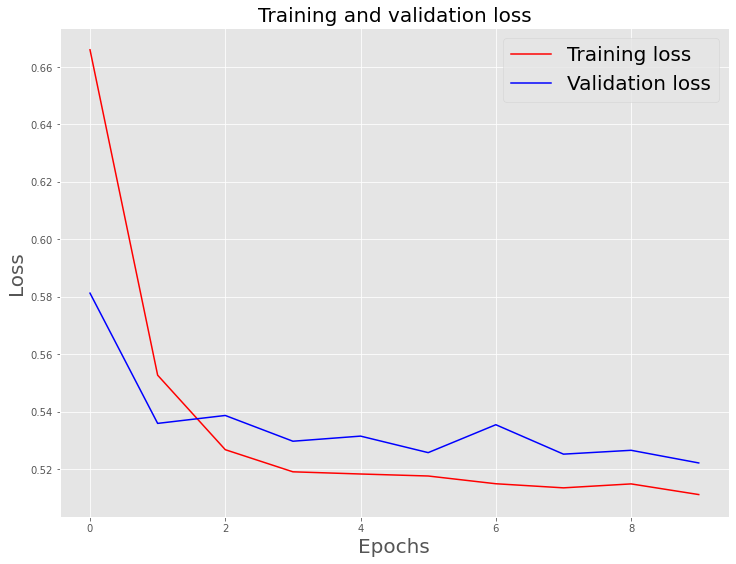

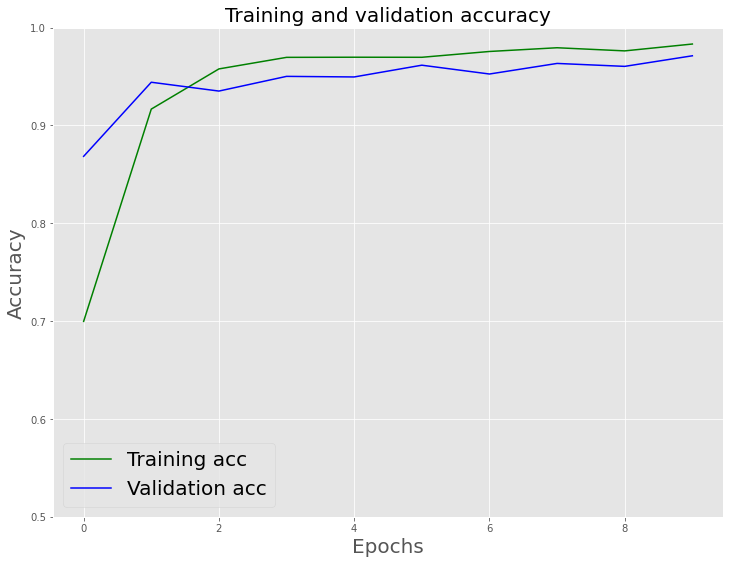

In [35]:
history_dict = history.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']
epochs = history.epoch

plt.figure(figsize=(12,9))
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss', size=20)
plt.xlabel('Epochs', size=20)
plt.ylabel('Loss', size=20)
plt.legend(prop={'size': 20})
plt.show()

plt.figure(figsize=(12,9))
plt.plot(epochs, acc, 'g', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy', size=20)
plt.xlabel('Epochs', size=20)
plt.ylabel('Accuracy', size=20)
plt.legend(prop={'size': 20})
plt.ylim((0.5,1))
plt.show()

Evaluate the testing set 

In [36]:
model.evaluate(X_test, Y_test)

130/130 [==============================] - 4s 31ms/step - loss: 0.5174 - accuracy: 0.9709


[0.5173599720001221, 0.9709134697914124]

In [37]:
pred = model.predict(X_test)

binary_predictions = []

for i in pred:
    if i >= 0.5:
        binary_predictions.append(1)
    else:
        binary_predictions.append(0) 

In [38]:
print('Accuracy on testing set:', accuracy_score(binary_predictions, Y_test))
print('Precision on testing set:', precision_score(binary_predictions, Y_test))
print('Recall on testing set:', recall_score(binary_predictions, Y_test))

Accuracy on testing set: 0.9709134615384616
Precision on testing set: 0.9716890595009597
Recall on testing set: 0.9702922855773838


Confusion matrix 

[Text(0, 0.5, '0'), Text(0, 1.5, '1')]

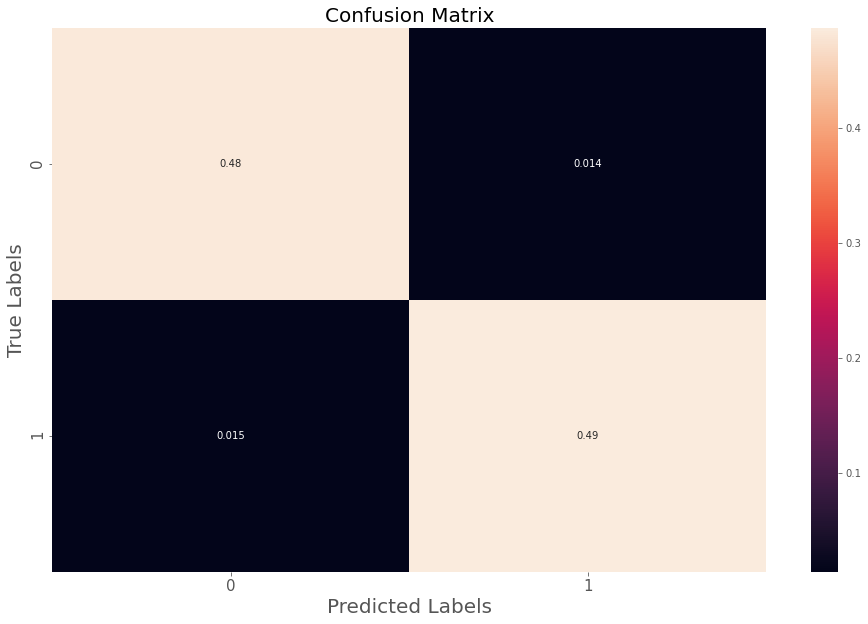

In [39]:
matrix = confusion_matrix(binary_predictions, Y_test, normalize='all')
plt.figure(figsize=(16, 10))
ax= plt.subplot()
sns.heatmap(matrix, annot=True, ax = ax)

# labels, title and ticks
ax.set_xlabel('Predicted Labels', size=20)
ax.set_ylabel('True Labels', size=20)
ax.set_title('Confusion Matrix', size=20) 
ax.xaxis.set_ticklabels([0,1], size=15)
ax.yaxis.set_ticklabels([0,1], size=15)

Saves the weights for visualiation

In [40]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_dim)

(10000, 32)


In [41]:
word_index = list(tokenizer.word_index.keys())
word_index = word_index[:max_vocab-1]

In [42]:
from sklearn.metrics import classification_report
print(classification_report(Y_test, binary_predictions))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97      2076
           1       0.97      0.97      0.97      2084

    accuracy                           0.97      4160
   macro avg       0.97      0.97      0.97      4160
weighted avg       0.97      0.97      0.97      4160



In [43]:
%%time
(model.predict(X_test[110])>0.5)[0]*1

CPU times: user 234 ms, sys: 5.49 ms, total: 240 ms
Wall time: 234 ms


array([0])

In [44]:
Y_test

13316    0
19826    0
3756     1
5833     0
15548    1
        ..
20109    0
1590     1
13386    1
19217    0
3461     1
Name: label, Length: 4160, dtype: int64